In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


Dataset Class from CSV

In [3]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        numFeat = 5 #------------------------
        numOut = 1
        self.X = np.empty([numFeat,len(self.df)-numFeat-numOut],dtype=np.float32)
        self.Y = np.empty([numOut,len(self.df)-numFeat-numOut],dtype=np.float32)
        for i in range(self.Y.shape[1]):
            self.X[:,i] = np.asarray(self.df.iloc[i:i+numFeat]["TOTAL"])
            self.Y[:,i] = np.asarray(self.df.iloc[i+numFeat:i+numFeat+numOut]["TOTAL"])

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)

    def __len__(self):
        return self.Y.shape[1]
    
    def __getitem__(self,idx):
        return self.X[:,idx].T, self.Y[:,idx]

Initialize test and train dataloaders

In [4]:
#create data loaders
train_data = dataSetAll(1900,2013)
test_data = dataSetAll(2013,2100)
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Create Neural Network Autoregression class

In [5]:
# create neural netowrk
class NeuralNetwork(nn.Module):
    def __init__(self):
        hidden = 40
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Create train and tet loops

In [6]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # print(pred)
        # print(y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # print(X)
            pred = model(X)
            # print(pred)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

Train the network

In [7]:
learning_rate = .000000001
batch_size = 64
epochs = 5000
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

C:\Users\mburs\AppData\Local\Temp\ipykernel_3564\1443783613.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3281.)
  return self.X[:,idx].T, self.Y[:,idx]


loss: 9274992.000000  [    0/  787]
Test Error:
Avg loss: 12454983.229167 

loss: 894738.937500  [    0/  787]
Test Error:
Avg loss: 9619443.125000 

loss: 720046.250000  [    0/  787]
Test Error:
Avg loss: 8059246.312500 

loss: 614819.000000  [    0/  787]
Test Error:
Avg loss: 6869676.239583 

loss: 535281.437500  [    0/  787]
Test Error:
Avg loss: 5958007.635417 

loss: 474853.906250  [    0/  787]
Test Error:
Avg loss: 5259094.937500 

loss: 429055.781250  [    0/  787]
Test Error:
Avg loss: 4716725.057292 

loss: 394236.500000  [    0/  787]
Test Error:
Avg loss: 4299198.411458 

loss: 368006.375000  [    0/  787]
Test Error:
Avg loss: 3964747.291667 

loss: 347531.843750  [    0/  787]
Test Error:
Avg loss: 3699913.270833 

loss: 331566.000000  [    0/  787]
Test Error:
Avg loss: 3494345.989583 

loss: 319015.031250  [    0/  787]
Test Error:
Avg loss: 3332820.447917 

loss: 308993.562500  [    0/  787]
Test Error:
Avg loss: 3204113.888021 

loss: 300957.343750  [    0/  787]
T

Test on single input

[[ 5905.  9567. 11036. 11729. 11385.]]
[[11554.917]]
[[11531.]]


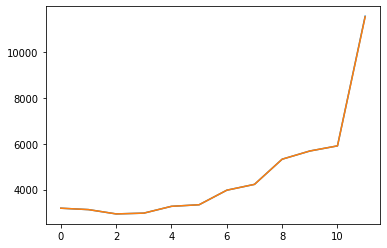

[[ 9567. 11036. 11729. 11385. 11531.]]
[[11995.142]]
[[12918.]]


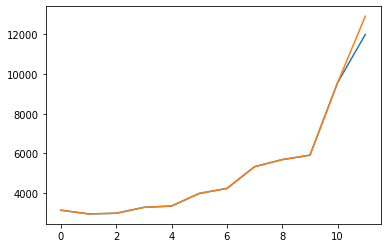

[[11036. 11729. 11385. 11531. 12918.]]
[[14214.39]]
[[13777.]]


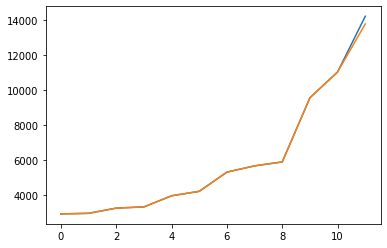

[[11729. 11385. 11531. 12918. 13777.]]
[[15203.167]]
[[16166.]]


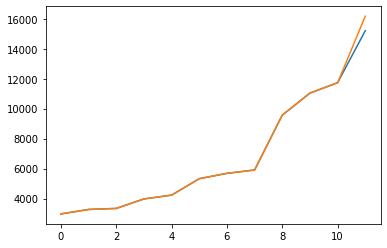

[[11385. 11531. 12918. 13777. 16166.]]
[[18433.998]]
[[18504.]]


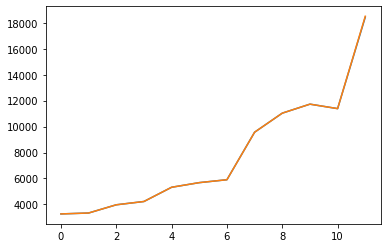

[[11531. 12918. 13777. 16166. 18504.]]
[[20885.305]]
[[23068.]]


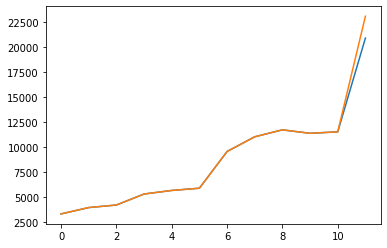

[[12918. 13777. 16166. 18504. 23068.]]
[[26643.52]]
[[29223.]]


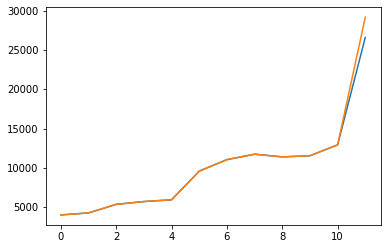

[[13777. 16166. 18504. 23068. 29223.]]
[[33248.95]]
[[37114.]]


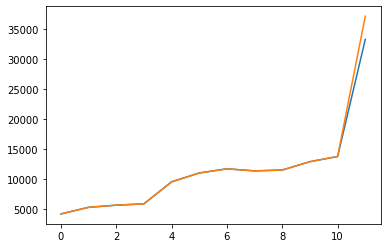

[[16166. 18504. 23068. 29223. 37114.]]
[[41275.227]]
[[42518.]]


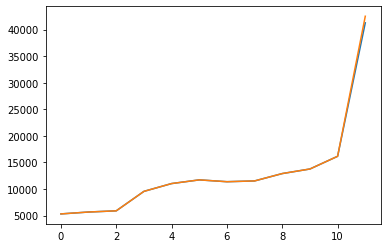

[[18504. 23068. 29223. 37114. 42518.]]
[[46034.637]]
[[38508.]]


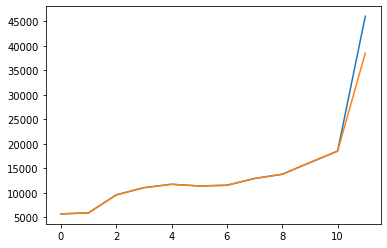

[[23068. 29223. 37114. 42518. 38508.]]
[[38564.574]]
[[35598.]]


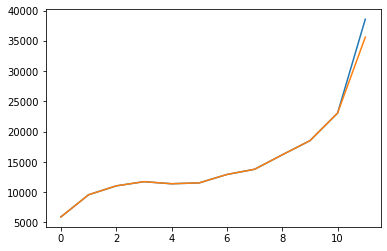

[[29223. 37114. 42518. 38508. 35598.]]
[[34610.387]]
[[34194.]]


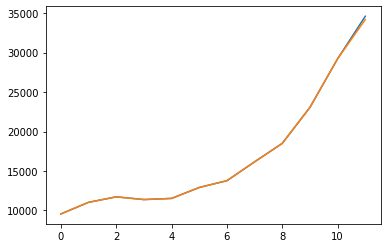

[[37114. 42518. 38508. 35598. 34194.]]
[[33557.473]]
[[32003.]]


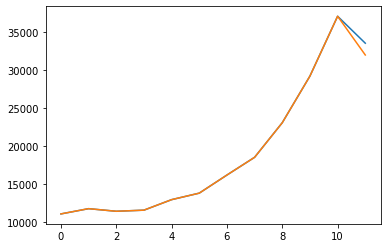

[[42518. 38508. 35598. 34194. 32003.]]
[[32778.004]]
[[29581.]]


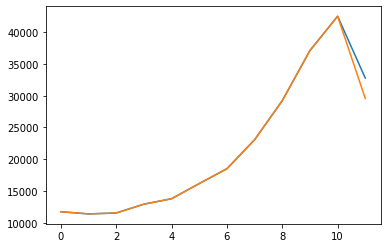

[[38508. 35598. 34194. 32003. 29581.]]
[[29778.545]]
[[26994.]]


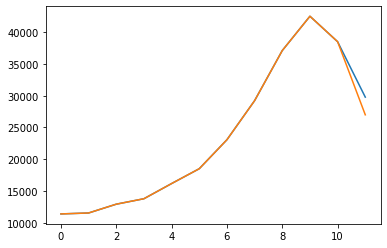

[[35598. 34194. 32003. 29581. 26994.]]
[[26652.795]]
[[24293.]]


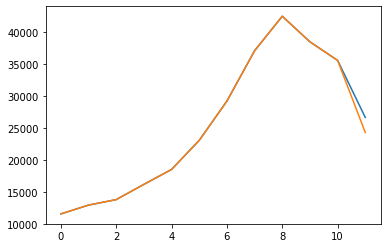

[[34194. 32003. 29581. 26994. 24293.]]
[[23850.203]]
[[22294.]]


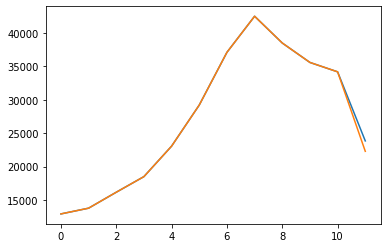

[[32003. 29581. 26994. 24293. 22294.]]
[[22136.959]]
[[20420.]]


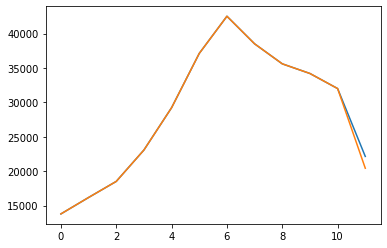

[[29581. 26994. 24293. 22294. 20420.]]
[[20413.186]]
[[19845.]]


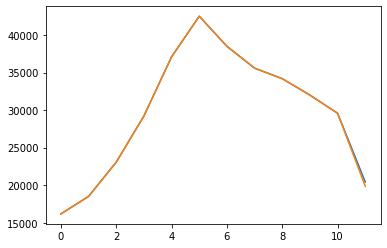

[[26994. 24293. 22294. 20420. 19845.]]
[[20560.07]]
[[18419.]]


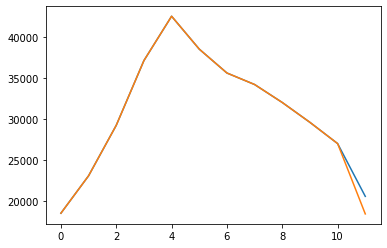

In [20]:
with torch.no_grad():
    model.eval()
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    for i in range(90,110):
        feat = test_data[i:i+1][0].numpy()
        pred = model(test_data[i:i+1][0]).numpy()
        act = test_data[i:i+1][1].numpy()
        full_back = data[i-10:i+1]
        print(feat)
        print(pred)
        print(act)
        # plt.plot(full_back)
        plt.plot(np.append(full_back,pred))
        plt.plot(np.append(full_back,act))
        plt.show()
